In [2]:
import numpy as np
from matplotlib import image as mpimg
import matplotlib.pyplot as plt

In [3]:
import numpy as np
from matplotlib import image as mpimg

def composite_slanted_slices(
    paths,
    angle_deg=0.0,
    line_thickness=0,
    line_xs=None,                # len == N-1, values in [0,1]
    crop_inputs=None,            # [x_min, x_max, y_min, y_max] in [0,1] or None
    line_color=(1, 1, 1),
    save_path=None,
):
    def _to_rgb(a):
        a = a.astype(np.float32)
        if a.dtype.kind in "ui": a /= 255.0
        if a.ndim == 2: a = np.repeat(a[..., None], 3, -1)
        if a.shape[-1] == 4: a = a[..., :3]
        return np.clip(a, 0, 1)

    imgs = [_to_rgb(mpimg.imread(p)) for p in paths]
    if not imgs: raise ValueError("No input images.")

    if crop_inputs is not None:
        xm, xM, ym, yM = crop_inputs
        for i, im in enumerate(imgs):
            H, W = im.shape[:2]
            x0 = 0 if xm is None else int(round(xm * W))
            x1 = W if xM is None else int(round(xM * W))
            y0 = 0 if ym is None else int(round(ym * H))
            y1 = H if yM is None else int(round(yM * H))
            imgs[i] = im[y0:y1, x0:x1, :]

    H, W = imgs[0].shape[:2]
    if any(im.shape[:2] != (H, W) for im in imgs):
        raise ValueError("All (cropped) images must have the same size.")
    N = len(imgs)
    if N == 1:
        out = imgs[0].copy()
        if save_path: mpimg.imsave(save_path, np.clip(out, 0, 1))
        return out

    a = np.deg2rad(angle_deg)
    y = np.arange(H)[:, None].astype(np.float32)
    x = np.arange(W)[None, :].astype(np.float32)
    cy = (H - 1) / 2.0
    xprime = x - (y - cy) * np.tan(a)

    if line_xs is None:
        thr = (np.arange(1, N) / N) * W
    else:
        if len(line_xs) != N - 1: raise ValueError("line_xs must have length N-1.")
        thr = np.clip(np.sort(np.asarray(line_xs, np.float32)), 0, 1) * W

    idx = np.searchsorted(thr, xprime, side="right")
    idx = np.clip(idx, 0, N - 1)

    out = np.empty((H, W, 3), dtype=np.float32)
    for i, im in enumerate(imgs):
        m = (idx == i)
        out[m] = im[m]

    if line_thickness and line_thickness > 0:
        c = np.asarray(line_color, np.float32)
        if c.max() > 1.0: c /= 255.0
        line_mask = np.zeros((H, W), bool)
        for t in np.atleast_1d(thr):
            line_mask |= np.abs(xprime - t) < (line_thickness / 2.0)
        out[line_mask] = c

    if save_path: mpimg.imsave(save_path, np.clip(out, 0, 1))
    return out



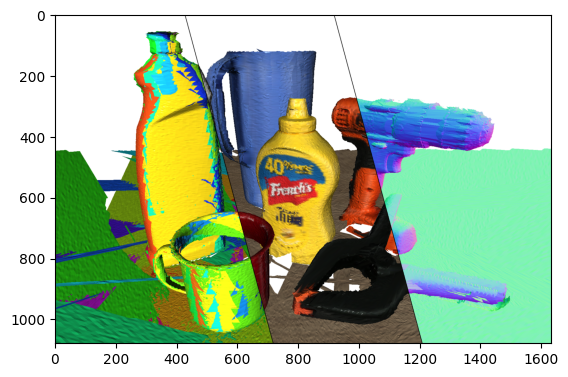

In [21]:
img = composite_slanted_slices(
    paths=[
        'scan_seg_noise.png',
        'scan_col_noise.png',
        'scan_nrm_noise.png',
    ],
    angle_deg=15,
    line_thickness=2,
    line_color=(0,0,0),
    line_xs=(0.35,0.65),
    save_path='scan_all_noise.png',
    crop_inputs=[0.1,0.95,None,0.95],
)
plt.imshow(img)